In [111]:
%pip install calplot


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Garmin Activity Analysis

I purchased a Garmin Forerunner 245 as a gift for losing 100lbs.  That was in early January and i was curious to see what I've done with this watch so far.

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output

pd.set_option('display.max_columns', 999)
%matplotlib inline
plt.style.use('ggplot')


In [113]:
df = pd.read_csv('data/garmin_activities.csv')
df_activities = df


## Data Cleaning

### Cleaning columns 'sport'

In [114]:
df_activities.loc[(df_activities['sport'] == 'fitness_equipment'),
                  'sport'] = df_activities['sub_sport']


In [115]:
df_activities['sport'] = pd.Categorical(df_activities['sport'])

# df_activities['elapsed_time'].dt.total_seconds

### Cleaning and adding time columns

In [116]:
df_activities['start_time'] = pd.to_datetime(df_activities['start_time'])


df_activities['start_date'] = df_activities['start_time'].apply(lambda x: x.date())
df_activities['hour'] = df_activities['start_time'].apply(lambda x: x.hour)


In [117]:
df_activities['start_date'] = pd.to_datetime(df_activities['start_date'])
df_activities['month'] = df_activities['start_date'].apply(lambda x: x.month)
df_activities['week'] = df_activities['start_date'].apply(lambda x: x.week)
df_activities['day_name'] = df_activities['start_date'].apply(lambda x: x.day_name())
df_activities['day_date'] = df_activities['start_date'].apply(lambda x: x.day)


In [118]:
df_activities['elapsed_time'] = pd.to_datetime(df_activities['elapsed_time'])

df_activities['start_hour'] = df_activities['elapsed_time'].apply(
    lambda x: x.hour)
df_activities['start_minute'] = df_activities['elapsed_time'].apply(
    lambda x: x.minute)
df_activities['start_second'] = df_activities['elapsed_time'].apply(
    lambda x: x.second)
df_activities['start_microsecond'] = df_activities['elapsed_time'].apply(
    lambda x: x.microsecond)


C:\Users\nsedl\AppData\Local\Temp\ipykernel_13260\3089110548.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_activities['elapsed_time'] = pd.to_datetime(df_activities['elapsed_time'])


In [119]:
# df_activities.loc[*]

In [120]:
df_activities.sort_values(by='start_time', ascending=True,
                          inplace=True, ignore_index=True)


In [121]:
df_activities['elapsed_time'] = pd.to_datetime(df_activities['elapsed_time'])


In [122]:
index = df_activities.loc[df_activities['elapsed_time'].dt.minute == 0].index
df_activities.drop(index, inplace=True)


In [123]:
# function to calculate calory/min, store h m s ms as variables
def calories_per_minute(df):
    hr = df['start_hour'] * 60
    min = df['start_minute']
    sec = df['start_second'] / 60
    ms = df['start_microsecond'] / 60000
    calories = df['calories']

    time = hr + min + sec + ms
    return calories / time


df_activities['calpermin'] = df_activities.apply(lambda x: calories_per_minute(
    x[['start_hour', 'start_minute', 'start_second', 'start_microsecond', 'calories']]), axis=1)

# df_activities['start_date'].dt.week


In [124]:
# function to calculate calory/min, store h m s ms as variables
def total_time(df):
    hr = df['start_hour'] * 60
    min = df['start_minute']
    sec = df['start_second'] / 60

    time = hr + min + sec 
    return time


df_activities['total_time'] = df_activities.apply(lambda x: total_time(
    x[['start_hour', 'start_minute', 'start_second', 'start_microsecond', ]]), axis=1)


In [125]:
def work_day(df):
    day = df['day_name']
    work_day 

    if day == 'Wednesday' or day == 'Thursday':
        return 'Off Day'
    else:
        return 'Work Day' 

df_activities['work_day'] = df_activities.apply(lambda x: work_day(x[['day_name']]), axis=1)

In [126]:
df_activities.head()


,activity_id,name,description,type,course_id,laps,sport,sub_sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,moving_time,distance,cycles,avg_hr,max_hr,avg_rr,max_rr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,max_temperature,min_temperature,avg_temperature,start_lat,start_long,stop_lat,stop_long,hr_zones_method,hrz_1_hr,hrz_2_hr,hrz_3_hr,hrz_4_hr,hrz_5_hr,hrz_1_time,hrz_2_time,hrz_3_time,hrz_4_time,hrz_5_time,start_date,hour,month,week,day_name,day_date,start_hour,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,10275535173,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-05-17 00:04:01,00:04:01.260000,0.000000,NaN,107.0,121.0,NaN,NaN,38,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:03:12.999000,00:00:18.862000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,0,4,1,0,9.460581,4.016667,Work Day
1,10275535206,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-05-17 00:04:46,00:04:46.379000,0.000000,NaN,121.0,127.0,NaN,NaN,60,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:44.698000,00:04:01.681000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,0,4,46,0,12.587413,4.766667,Work Day
2,10275535247,Treadmill Running,NaN,uncategorized,NaN,2,running,treadmill,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-05-17 00:11:54,00:11:54.340000,0.999998,868.0,154.0,166.0,NaN,NaN,218,73.0,76.0,5.039817,6.534090,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:15.000000,00:00:21.001000,00:02:20.000000,00:08:09.335000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,0,11,54,0,18.319328,11.900000,Work Day
3,10275535278,Treadmill Running,NaN,uncategorized,NaN,2,running,treadmill,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-05-17 00:12:42,00:12:42.370000,1.081434,918.0,164.0,173.0,NaN,NaN,249,72.0,78.0,5.106925,6.135916,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:00.000000,00:00:27.063000,00:02:11.307000,00:10:03.997000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,0,12,42,0,19.606299,12.700000,Work Day
4,10278242382,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-05-17 00:14:17,00:14:17.384000,0.000000,NaN,115.0,137.0,NaN,NaN,152,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:06:29.195000,00:06:35.999000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,20,1,2,Monday,9,0,14,17,0,10.641774,14.283333,Work Day


In [127]:
df_activities.columns


Index(['activity_id', 'name', 'description', 'type', 'course_id', 'laps',
       'sport', 'sub_sport', 'training_effect', 'anaerobic_training_effect',
       'start_time', 'stop_time', 'elapsed_time', 'moving_time', 'distance',
       'cycles', 'avg_hr', 'max_hr', 'avg_rr', 'max_rr', 'calories',
       'avg_cadence', 'max_cadence', 'avg_speed', 'max_speed', 'ascent',
       'descent', 'max_temperature', 'min_temperature', 'avg_temperature',
       'start_lat', 'start_long', 'stop_lat', 'stop_long', 'hr_zones_method',
       'hrz_1_hr', 'hrz_2_hr', 'hrz_3_hr', 'hrz_4_hr', 'hrz_5_hr',
       'hrz_1_time', 'hrz_2_time', 'hrz_3_time', 'hrz_4_time', 'hrz_5_time',
       'start_date', 'hour', 'month', 'week', 'day_name', 'day_date',
       'start_hour', 'start_minute', 'start_second', 'start_microsecond',
       'calpermin', 'total_time', 'work_day'],
      dtype='object')

In [128]:
df_activities = df_activities[[
    'name', 'sport', 'training_effect', 'anaerobic_training_effect',
    'start_time', 'stop_time', 'elapsed_time',
    'distance', 'avg_hr', 'max_hr', 'calories',
    'avg_cadence', 'max_cadence', 'avg_speed', 'max_speed', 'ascent',
    'descent', 'start_lat', 'start_long', 'stop_lat', 'stop_long',
    'start_date', 'hour', 'month', 'week', 'day_name', 'day_date', 'start_minute', 'start_second',
    'start_microsecond', 'calpermin', 'total_time', 'work_day'
]]


In [129]:
df_activities.describe()

,training_effect,anaerobic_training_effect,start_time,elapsed_time,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,start_date,hour,month,week,day_date,start_minute,start_second,start_microsecond,calpermin,total_time
count,196.000000,196.000000,196,196,196.000000,196.000000,196.000000,196.000000,151.000000,154.000000,196.000000,114.000000,47.000000,48.000000,48.000000,48.000000,48.000000,48.000000,196,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,2.088776,0.028571,2023-03-04 15:55:50.892857088,2023-05-17 00:22:21.619484672,1.170884,137.785714,156.005102,277.775510,59.596026,72.870130,2.615678,6.069632,248.296756,265.953084,39.108467,-84.642300,39.108337,-84.642288,2023-03-04 03:03:40.408163328,12.346939,2.571429,9.341837,15.918367,21.719388,20.086735,2137.755102,12.256677,22.360289
min,0.000000,0.000000,2023-01-09 11:14:38,2023-05-17 00:02:31,0.000000,75.000000,105.000000,24.000000,3.000000,26.000000,0.000000,2.442734,65.616798,9.842520,39.104707,-84.643636,39.104367,-84.644019,2023-01-09 00:00:00,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,2.950166,2.516667
25%,1.275000,0.000000,2023-01-29 11:55:16.500000,2023-05-17 00:11:51.249999872,0.000000,126.000000,143.000000,146.000000,49.000000,73.250000,0.000000,5.030869,170.603675,169.783465,39.108395,-84.643102,39.108293,-84.643100,2023-01-29 00:00:00,11.000000,1.000000,4.000000,8.750000,11.000000,5.000000,0.000000,10.608789,11.854167
50%,2.400000,0.000000,2023-02-22 03:39:18,2023-05-17 00:21:23.500000,1.001234,139.000000,162.500000,265.000000,69.000000,78.000000,4.142805,5.354106,242.782153,239.501313,39.108462,-84.643004,39.108452,-84.643014,2023-02-21 12:00:00,11.000000,2.000000,8.000000,16.000000,20.500000,13.500000,0.000000,12.089665,21.391667
75%,2.900000,0.000000,2023-04-08 17:17:30.500000,2023-05-17 00:30:34.249999872,2.253376,152.000000,170.000000,393.500000,73.000000,80.000000,4.622628,5.902156,288.713911,319.881890,39.108572,-84.642720,39.108533,-84.642452,2023-04-08 06:00:00,12.000000,4.000000,14.000000,24.000000,30.000000,34.000000,0.000000,14.218949,30.570833
max,4.000000,0.900000,2023-05-17 11:27:47,2023-05-17 01:12:13,5.103514,170.000000,185.000000,814.000000,77.000000,120.000000,6.491588,49.695769,675.853019,816.929135,39.112093,-84.635264,39.111659,-84.635187,2023-05-17 00:00:00,22.000000,5.000000,20.000000,31.000000,59.000000,59.000000,419000.000000,19.606299,72.216667
std,1.020496,0.113228,NaN,NaN,1.237635,16.938047,18.301043,163.910234,19.176784,19.578133,2.295644,4.698009,120.765113,155.110055,0.001167,0.001965,0.001277,0.001965,NaN,3.175554,1.362501,5.580229,9.057280,12.324161,17.649221,29928.571429,2.587006,12.779089


In [130]:
df_activities.head()

,name,sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,start_date,hour,month,week,day_name,day_date,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,Indoor Cycling,cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-05-17 00:04:01,0.000000,107.0,121.0,38,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,1,0,9.460581,4.016667,Work Day
1,Indoor Cycling,cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-05-17 00:04:46,0.000000,121.0,127.0,60,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,46,0,12.587413,4.766667,Work Day
2,Treadmill Running,running,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-05-17 00:11:54,0.999998,154.0,166.0,218,73.0,76.0,5.039817,6.534090,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,11,54,0,18.319328,11.900000,Work Day
3,Treadmill Running,running,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-05-17 00:12:42,1.081434,164.0,173.0,249,72.0,78.0,5.106925,6.135916,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,12,42,0,19.606299,12.700000,Work Day
4,Indoor Cycling,cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-05-17 00:14:17,0.000000,115.0,137.0,152,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,20,1,2,Monday,9,14,17,0,10.641774,14.283333,Work Day


## Data Visualization

Text(0.5, 1.0, 'Activities Amount')

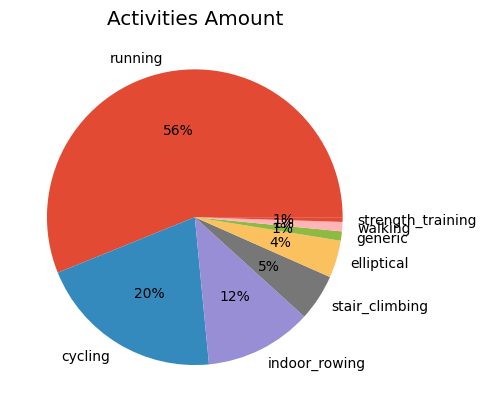

In [131]:
activities_pie = df_activities['sport'].value_counts().plot(
    kind='pie', autopct='%.0f%%',)
activities_pie.set_ylabel('')
activities_pie.set_title('Activities Amount')


<Axes: title={'center': 'Average Calories Burned per Activity'}, xlabel='sport'>

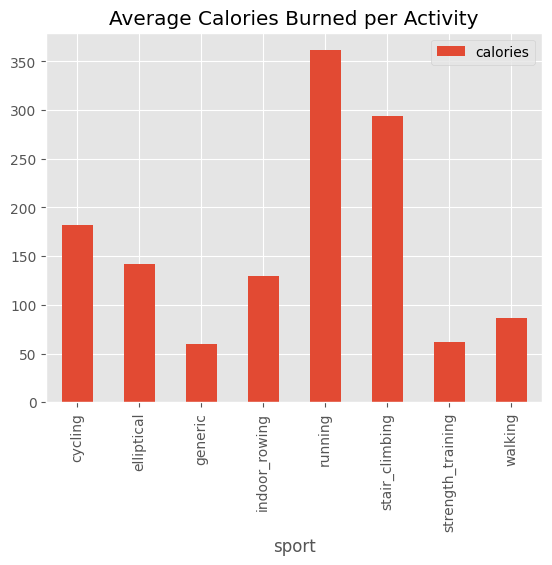

In [132]:
df_activities.groupby('sport').agg({
    'calories': 'mean'
}).plot(kind='bar', title='Average Calories Burned per Activity')


<Axes: xlabel='day_name', ylabel='calories'>

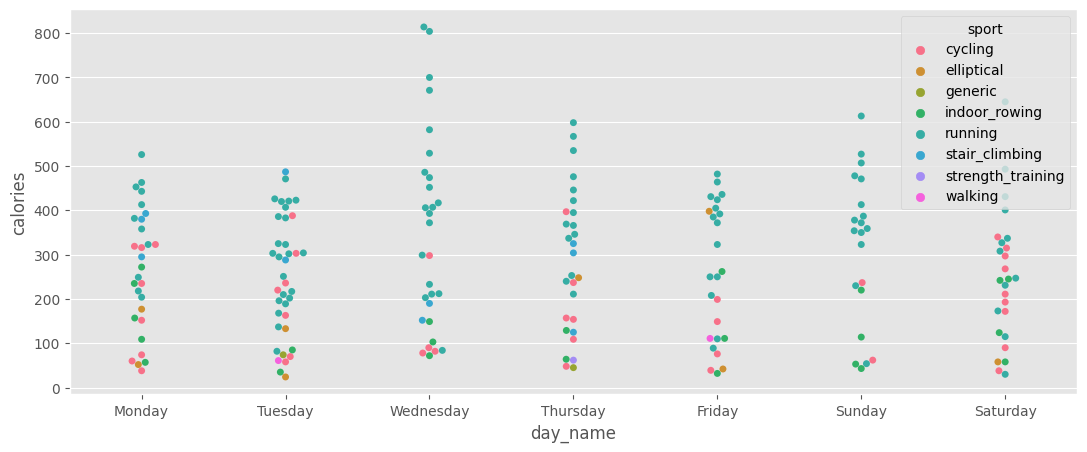

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.swarmplot(data=df_activities, x='day_name', y='calories', hue='sport', ax=ax,)


c:\Python310\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='day_name', ylabel='hour'>

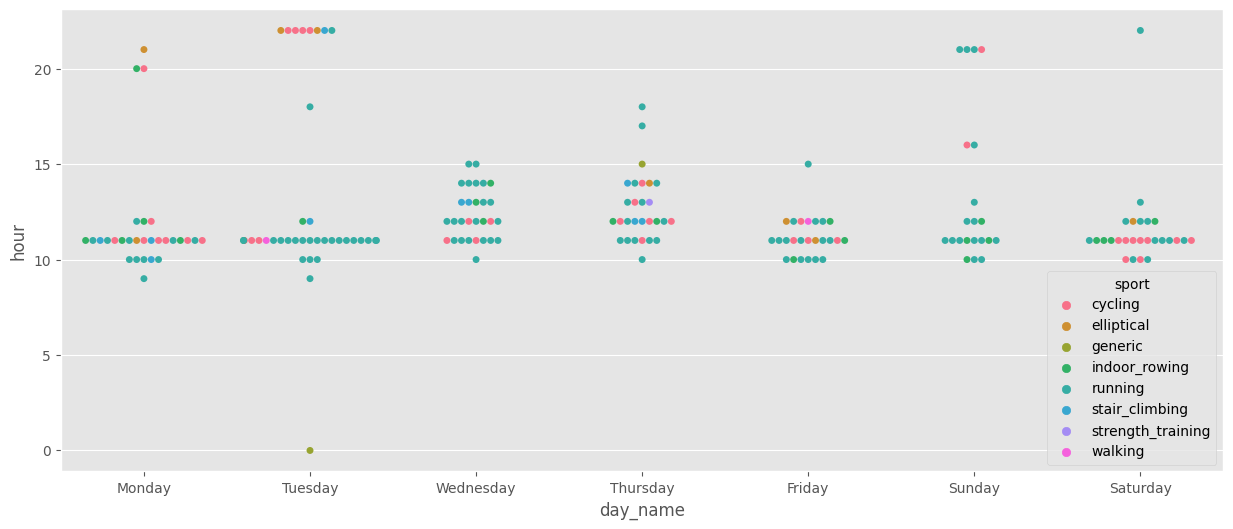

In [134]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.swarmplot(x='day_name', y='hour', data=df_activities, hue='sport', size=5)

<Axes: xlabel='week', ylabel='calories'>

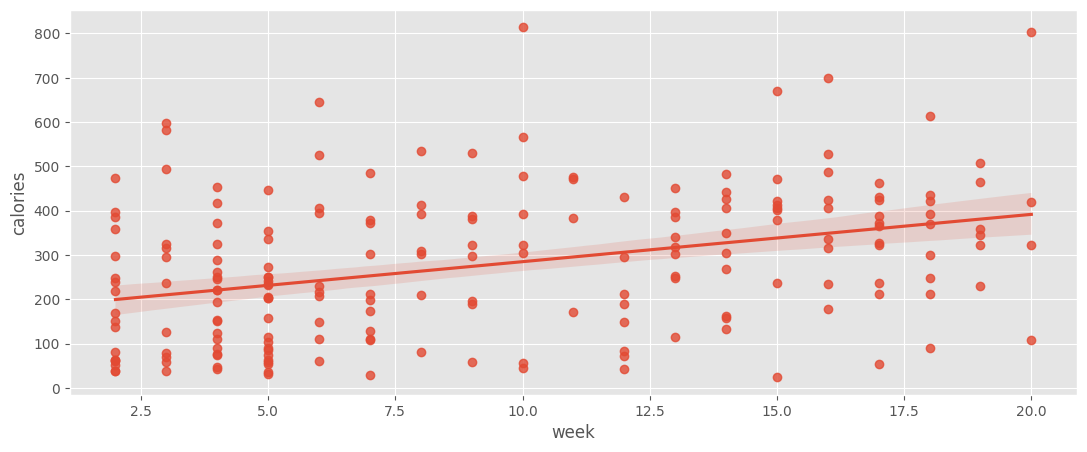

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.regplot(data=df_activities, x='week', y='calories',)


<Axes: xlabel='week', ylabel='avg_hr'>

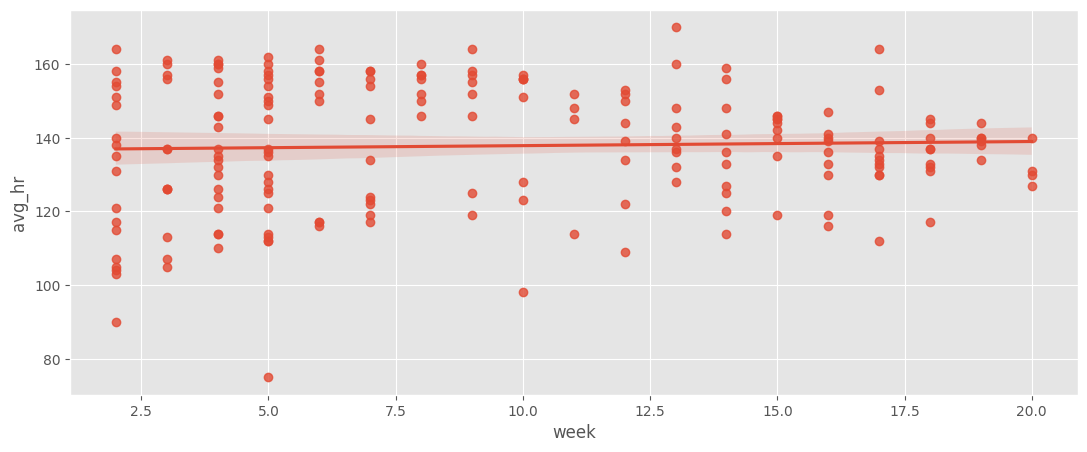

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.regplot(data=df_activities, x='week', y='avg_hr',)


<Axes: title={'center': 'Count of Start Hour'}, ylabel='Frequency'>

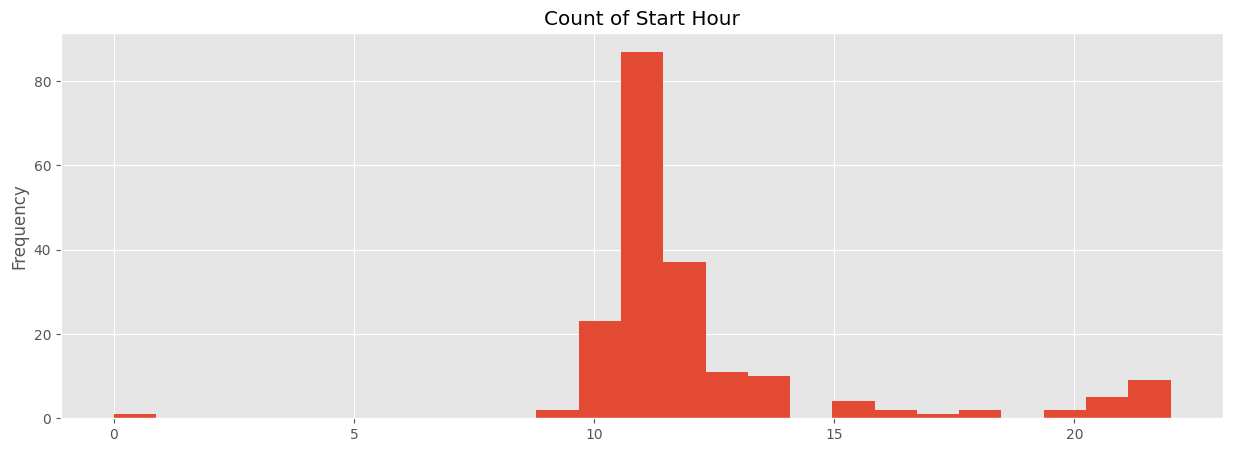

In [137]:
fig, ax1 = plt.subplots(figsize=(15, 5))

df_activities['hour'].plot(kind='hist', bins=25, title='Count of Start Hour')


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


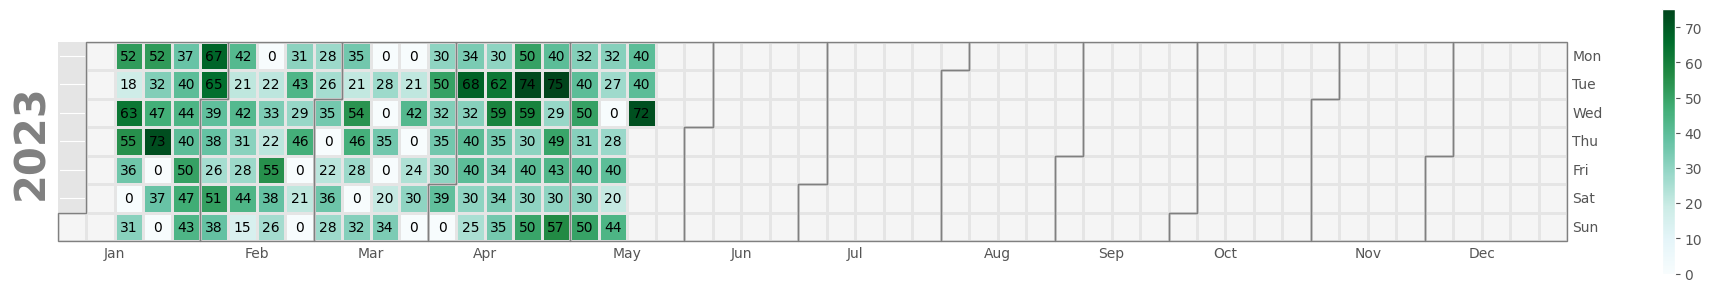

In [138]:
df__index = df_activities.set_index('start_date')
pl1 = calplot.calplot(data=df__index['total_time'], how='sum', figsize=(
    20, 3), suptitle='', textformat="{:1.0f}", cmap='BuGn', )


<Axes: xlabel='total_time', ylabel='Density'>

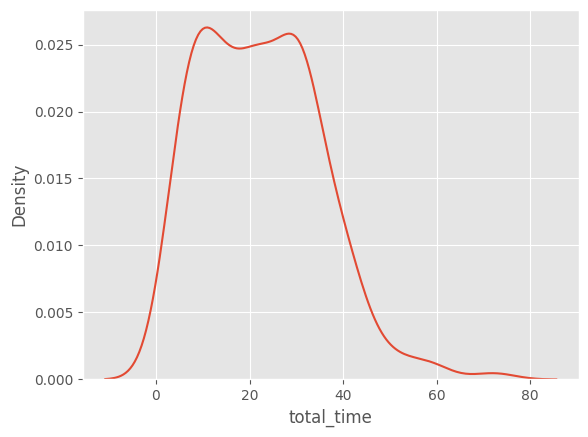

In [139]:
sns.kdeplot(data=df_activities, x='total_time')

C:\Users\nsedl\AppData\Local\Temp\ipykernel_13260\4270111377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_activities['day_name'] = pd.Categorical(df_activities['day_name'], categories=days_ordered)


<Axes: xlabel='week', ylabel='day_name'>

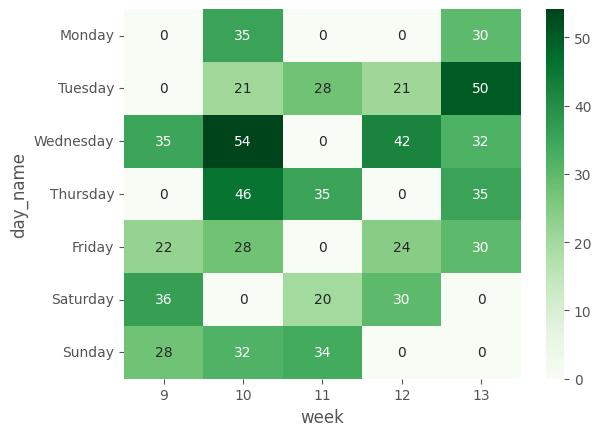

In [140]:
days_ordered = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_activities['day_name'] = pd.Categorical(df_activities['day_name'], categories=days_ordered)
df_activities = df_activities.sort_values('start_date')
df_test = df_activities.loc[df_activities['month'] == 3]
piv = pd.pivot_table(
    columns=df_test['week'], values='total_time', index='day_name', aggfunc='sum', data=df_test)
piv.sort_index(axis=1, ascending=True, inplace=True,)
sns.heatmap(piv, cmap='Greens', annot=True, )
# pivActivity Time Calendar
# df_test
# df_activities.loc[(df_activities['week'] == 9),]

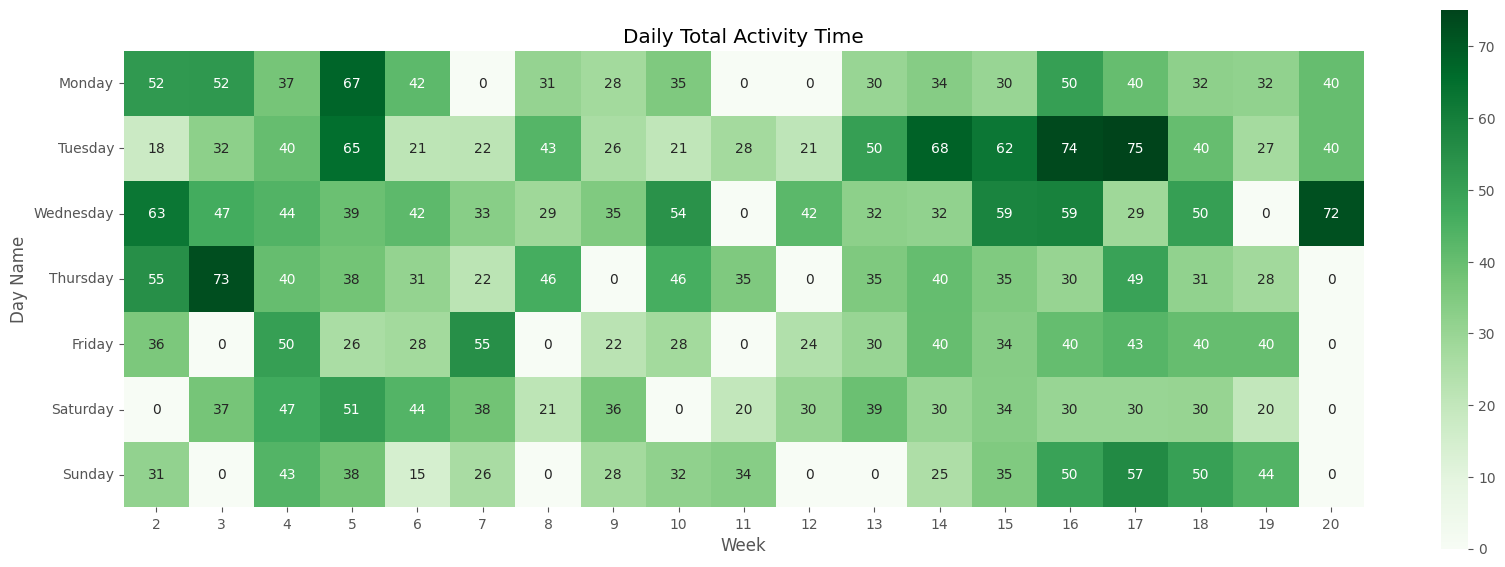

In [141]:
fig, ax = plt.subplots(figsize=(20, 7))

df_running = df_activities.loc[(df_activities['sport'].str.contains('running'))]
piv = pd.pivot_table(
    columns=df_activities['week'], values='total_time', index='day_name', aggfunc='sum', data=df_activities)
sns.heatmap(piv, cmap='Greens', annot=True, square=True, ax=ax, fmt='.0f')
ax.set_title('Daily Total Activity Time')
ax.set_xlabel('Week')
ax.set_ylabel('Day Name')

plt.show()

<Axes: title={'center': 'Calories Burned Per Minute'}, xlabel='Calories', ylabel='Activity'>

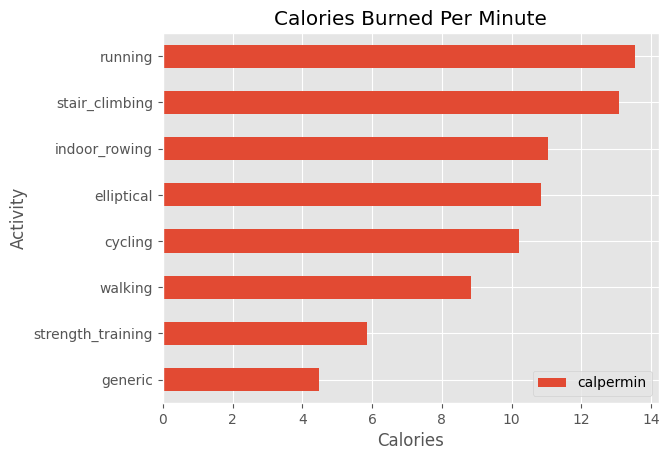

In [142]:
df_activities.groupby('sport').agg({
    'calpermin': 'mean'
}).sort_values('calpermin', ascending=True).plot(kind='barh', title='Calories Burned Per Minute', xlabel='Calories', ylabel='Activity')


<Axes: xlabel='week', ylabel='total_time'>

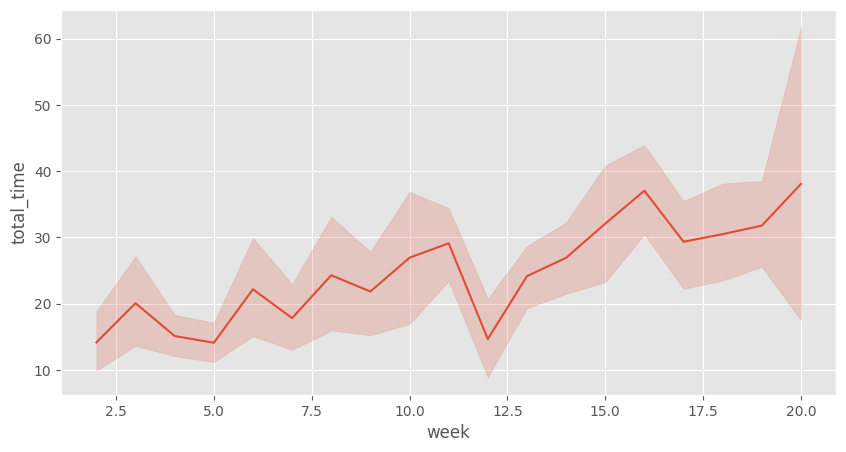

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_activities, x='week', y='total_time',)


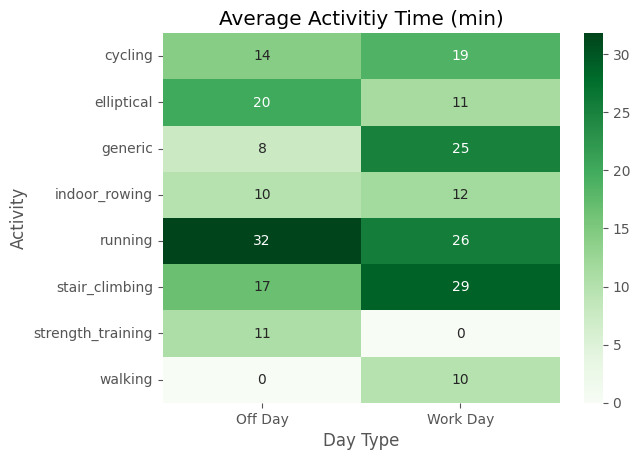

In [144]:
piv = pd.pivot_table(
    columns=df_activities['work_day'], values='total_time', index='sport', aggfunc='mean', data=df_activities,).fillna(0)
work_day_hm = sns.heatmap(piv, cmap='Greens', annot=True, fmt='.0f',)
work_day_hm.set_title('Average Activitiy Time (min)')
work_day_hm.set_xlabel('Day Type')
work_day_hm.set_ylabel('Activity')
plt.show()

In [151]:
# df_activities.to_csv('data/activities_dashboard.csv')

In [152]:
df_activities

,name,sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,start_date,hour,month,week,day_name,day_date,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,Indoor Cycling,cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-05-17 00:04:01,0.000000,107.0,121.0,38,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,1,0,9.460581,4.016667,Work Day
1,Indoor Cycling,cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-05-17 00:04:46,0.000000,121.0,127.0,60,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,46,0,12.587413,4.766667,Work Day
2,Treadmill Running,running,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-05-17 00:11:54,0.999998,154.0,166.0,218,73.0,76.0,5.039817,6.534090,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,11,54,0,18.319328,11.900000,Work Day
3,Treadmill Running,running,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-05-17 00:12:42,1.081434,164.0,173.0,249,72.0,78.0,5.106925,6.135916,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,12,42,0,19.606299,12.700000,Work Day
4,Indoor Cycling,cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-05-17 00:14:17,0.000000,115.0,137.0,152,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,20,1,2,Monday,9,14,17,0,10.641774,14.283333,Work Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Delhi - Goal Pace Repeats,running,2.7,0.0,2023-05-14 12:12:54,2023-05-14 12:57:00.000000,2023-05-17 00:43:56,3.218840,139.0,164.0,507,66.0,80.0,4.395579,6.053149,236.220473,232.939633,39.108524,-84.643035,39.108474,-84.643066,2023-05-14,12,5,19,Sunday,14,43,56,0,11.540212,43.933333,Work Day
193,Treadmill Running,running,2.6,0.0,2023-05-15 10:49:04,2023-05-15 11:19:39.000000,2023-05-17 00:30:00,2.099999,131.0,154.0,323,66.0,82.0,4.198729,4.737831,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-15,10,5,20,Monday,15,30,0,0,10.766667,30.000000,Work Day
194,Indoor Rowing,indoor_rowing,1.0,0.0,2023-05-15 11:23:27,2023-05-15 11:33:45.000000,2023-05-17 00:10:03,0.000000,127.0,136.0,109,26.0,29.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-15,11,5,20,Monday,15,10,3,0,10.845771,10.050000,Work Day
195,Easy Run,running,2.5,0.0,2023-05-16 10:52:08,2023-05-16 11:32:30.000000,2023-05-17 00:40:01,2.720003,130.0,150.0,420,67.0,105.0,4.077934,5.238904,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-16,10,5,20,Tuesday,16,40,1,0,10.495627,40.016667,Work Day
